In [1]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
from bs4 import BeautifulSoup

import torch
import requests

import os

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

rates = requests.get("https://api.exchangerate-api.com/v4/latest/USD").json()['rates']
rates['RUR'] = rates['RUB']
rates['BYR'] = rates['BYN']

Select either embedding or vllm

In [2]:
from sentence_transformers import SentenceTransformer

models = [
    "intfloat/multilingual-e5-large-instruct",
    "dunzhang/stella_en_1.5B_v5",
    "dunzhang/stella_en_400M_v5",
    "deepvk/USER-bge-m3",
    "jinaai/jina-embeddings-v3"
]

embedding_model = SentenceTransformer(models[0], trust_remote_code=True).cuda()

/home/netkit/Projects/analytics/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
from vllm import LLM

os.environ["VLLM_ATTENTION_BACKEND"] = "FLASHINFER"
os.environ["HF_TOKEN"] = os.environ['HF_TOKEN']

llm = LLM("google/gemma-2-2b-it")
# llm = LLM("Qwen/Qwen2.5-3B-Instruct", max_model_len=16000)

# model_id = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
# model_id = "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit"
# model_id = "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"
# llm = LLM(model=model_id, dtype=torch.bfloat16, trust_remote_code=True, quantization="bitsandbytes", load_format="bitsandbytes", max_model_len=4096)

WARNING 10-09 20:06:45 utils.py:747] Gemma 2 uses sliding window attention for every odd layer, which is currently not supported by vLLM. Disabling sliding window and capping the max length to the sliding window size (4096).
INFO 10-09 20:06:45 llm_engine.py:226] Initializing an LLM engine (v0.6.1.dev238+ge2c6e0a82) with config: model='google/gemma-2-2b-it', speculative_config=None, tokenizer='google/gemma-2-2b-it', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces

In [14]:
from vllm import SamplingParams

sampling_params = SamplingParams(temperature=0, top_p=0.95, max_tokens=512, repetition_penalty=1.5)

In [5]:
df = pd.read_parquet('generated_nlp_features_v5.2_final.parquet')
df.shape

(20859, 32)

In [3]:
roles = [
    "Backend Developer",
    "Frontend Developer",
    "Full Stack Developer",
    "DevOps Engineer",
    "Mobile App Developer",
    "Machine Learning Engineer",
    "MLOps Engineer",
    "Data Scientist",
    "Data Engineer",
    "Software Architect",
    "Cloud Engineer",
    "Site Reliability Engineer (SRE)",
    "Database Administrator (DBA)",
    "Security Engineer",
    "QA Engineer",
    "ERP Developer",
    "ERP Consultant",
    "ERP Analyst",
    "Business Intelligence (BI) Developer",
    "Network Engineer",
    "Systems Administrator",
    "IT Support Specialist",
    "Game Developer",
    "UI/UX Designer",
    "Blockchain Developer",
    "Artificial Intelligence (AI) Researcher",
    "Embedded Systems Engineer",
    "Solutions Architect",
    "IT Project Manager",
    "Technical Lead",
    "IT Consultant",
    "Product Manager (Tech)",
    "IT Operations Manager",
    "Research Scientist (AI/ML)",
    "Data Analyst",
    "Natural Language Processing (NLP) Engineer",
    "Computer Vision Engineer",
    "Robotics Engineer",
    "Quantum Computing Researcher",
    "Cybersecurity Analyst",
    "Penetration Tester",
    "Ethical Hacker",
    "Augmented Reality (AR) Developer",
    "Virtual Reality (VR) Developer",
    "Firmware Engineer",
    "Chief Technology Officer (CTO)",
    "Chief Information Officer (CIO)",
    "Technical Program Manager",
    "Hardware Engineer",
    "IoT Engineer",
    "Big Data Engineer",
    "Algorithm Engineer",
    "Research Software Engineer",
    "Bioinformatics Engineer",
    "IT Risk Analyst",
    "Teacher",
    "Fraud Specialist",
    "Tech Support Specialist",
    "Mechanical Engineer",
    "Electrical Engineer",
    "2D Designer",
    "3D Designer",
]

def build_role_query(role: str):
    return f"Instruct: Given a query, retreive relevant passages that answer the query\nQuery: name of vacancy for a role {role}"

role_queries = list(map(build_role_query, roles))
role_embeddings = embedding_model.encode(role_queries, show_progress_bar=True, normalize_embeddings=True)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
text_embeddings = embedding_model.encode(list(df['name']), show_progress_bar=True, normalize_embeddings=True)

Batches:   0%|          | 0/652 [00:00<?, ?it/s]

In [ ]:
# Calculate cosine similarity between text embeddings and role embeddings
text_role_similarities = cosine_similarity(text_embeddings, role_embeddings)

# Find the best suited role for each text
best_role_indices = np.argmax(text_role_similarities, axis=1)

# Create a new column 'best_suited_role' in the dataframe
df['best_role'] = [roles[i] for i in best_role_indices]

# Add similarity scores for the best suited role
df['best_role_similarity'] = np.max(text_role_similarities, axis=1)

In [3]:
import glob

file_paths = glob.glob('full_vacs*.parquet')

dfs = []

for file_path in file_paths:
    df_temp = pd.read_parquet(file_path)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
df = df.drop_duplicates(subset='id')
df = df[['id', 'name', 'area', 'address', 'salary', 'experience', 'description', 'key_skills', 'professional_roles', 'published_at', 'languages', 'employer', 'schedule', 'employment']]

df['area'] = df['area'].apply(lambda area: area['name'])
df['currency'] = df['salary'].apply(lambda salary: salary['currency'])
df['experience'] = df['experience'].apply(lambda exp: exp['name'])
df['key_skills'] = df['key_skills'].apply(lambda ks: list(map(lambda s: s['name'].lower(), ks)))
df['professional_roles'] = df['professional_roles'].apply(lambda prs: list(map(lambda pr: pr['name'], prs))[0])
df['published_at'] = pd.to_datetime(df['published_at'])
df['published_date'] = df['published_at'].dt.date
df['description'] = df['description'].apply(lambda desc: BeautifulSoup(desc).get_text().lower())
df['employer'] = df['employer'].apply(lambda employer: employer['name'])

df['salary_from'] = df['salary'].apply(lambda salary: salary['from'])
df['salary_to'] = df['salary'].apply(lambda salary: salary['to'])
df['employment'] = df['employment'].apply(lambda employment: employment['id'])
df['schedule'] = df['schedule'].apply(lambda sch: sch['id'])

salary_range_pct = 25.0

def calculate_mean_salary(row, pct):
    if pd.notna(row['salary_from']) and pd.notna(row['salary_to']):
        return (row['salary_from'] + row['salary_to']) / 2
    elif pd.notna(row['salary_from']):
        return row['salary_from'] * (1 + pct / 100)
    elif pd.notna(row['salary_to']):
        return row['salary_to'] * (1 - pct / 100)
    else:
        return np.nan


df['mean_salary'] = df.apply(lambda row: calculate_mean_salary(row, salary_range_pct), axis=1)
df['mean_salary_usd'] = df.apply(lambda row: row['mean_salary'] / rates[row['currency']], axis=1)

df = df.drop(columns=['address'])

area_counts = df['area'].value_counts()
areas_with_more_than_10_entries = area_counts[area_counts > 10].index

df = df[df['area'].isin(areas_with_more_than_10_entries)]

currency_counts = df['currency'].value_counts()
currency_with_more_than_100_entries = currency_counts[currency_counts > 100].index

df = df[df['currency'].isin(currency_with_more_than_100_entries)]

# If vacancy contains word высшее or higher than we can assume that higher education is required
df['education'] = df['description'].apply(lambda desc: int("высшее" in desc or "higher" in desc))

df.sort_values(by='mean_salary_usd', inplace=True)

# Fix salaries where thouthands are ommited
df.loc[(df['currency'].isin(['RUR', 'KZT'])) & (df['mean_salary_usd'] < 10), 'mean_salary_usd'] *= 1000

/tmp/ipykernel_1769/2176667815.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['description'] = df['description'].apply(lambda desc: BeautifulSoup(desc).get_text().lower())


In [11]:
q1 = df['mean_salary_usd'].quantile(0.01)
q99 = df['mean_salary_usd'].quantile(0.99)

df = df[(df['mean_salary_usd'] >= q1) & (df['mean_salary_usd'] <= q99)]

df = df.reset_index(drop=True)

<Figure size 1200x800 with 0 Axes>

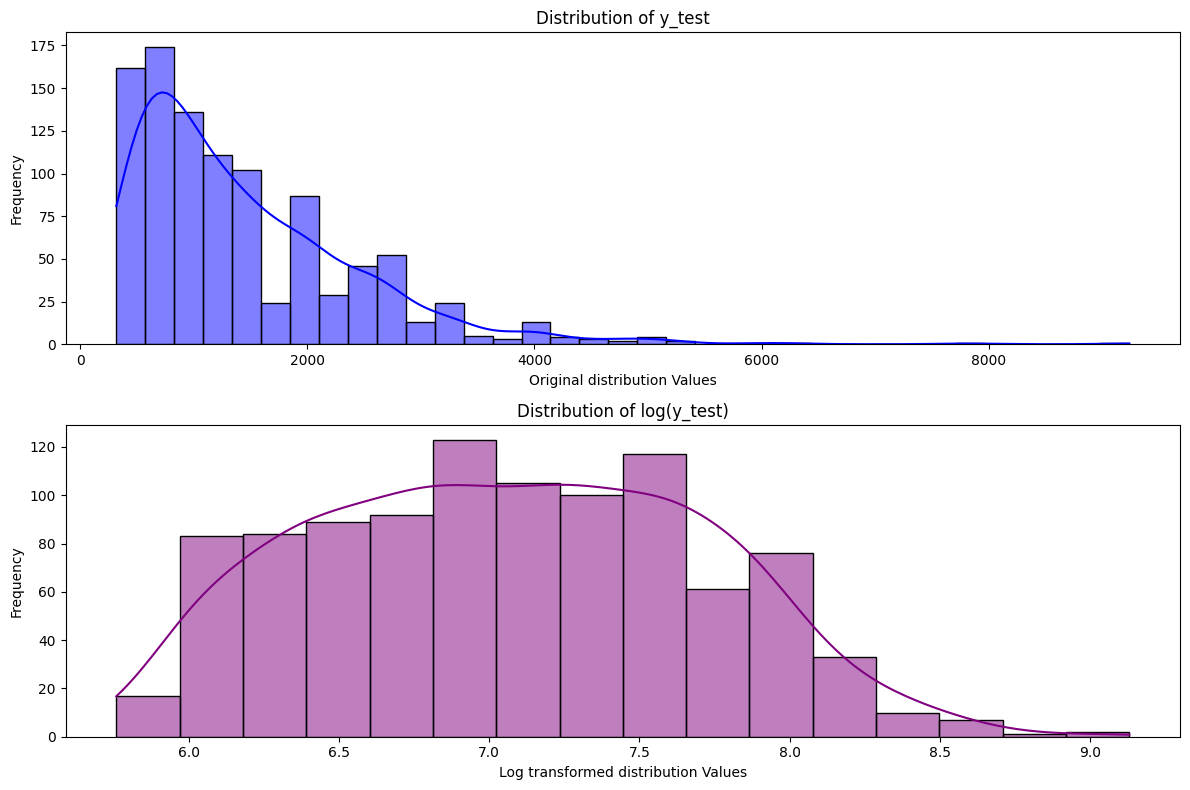

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(12, 8))

# Plot original distribution
plt.subplot(2, 1, 1)
sns.histplot(df['mean_salary_usd'], kde=True, color='blue')
plt.xlabel('Original distribution Values')
plt.ylabel('Frequency')
plt.title('Distribution of y_test')

# Plot log-transformed distribution
plt.subplot(2, 1, 2)
sns.histplot(np.log(df['mean_salary_usd']), kde=True, color='purple')
plt.xlabel('Log transformed distribution Values')
plt.ylabel('Frequency')
plt.title('Distribution of log(y_test)')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

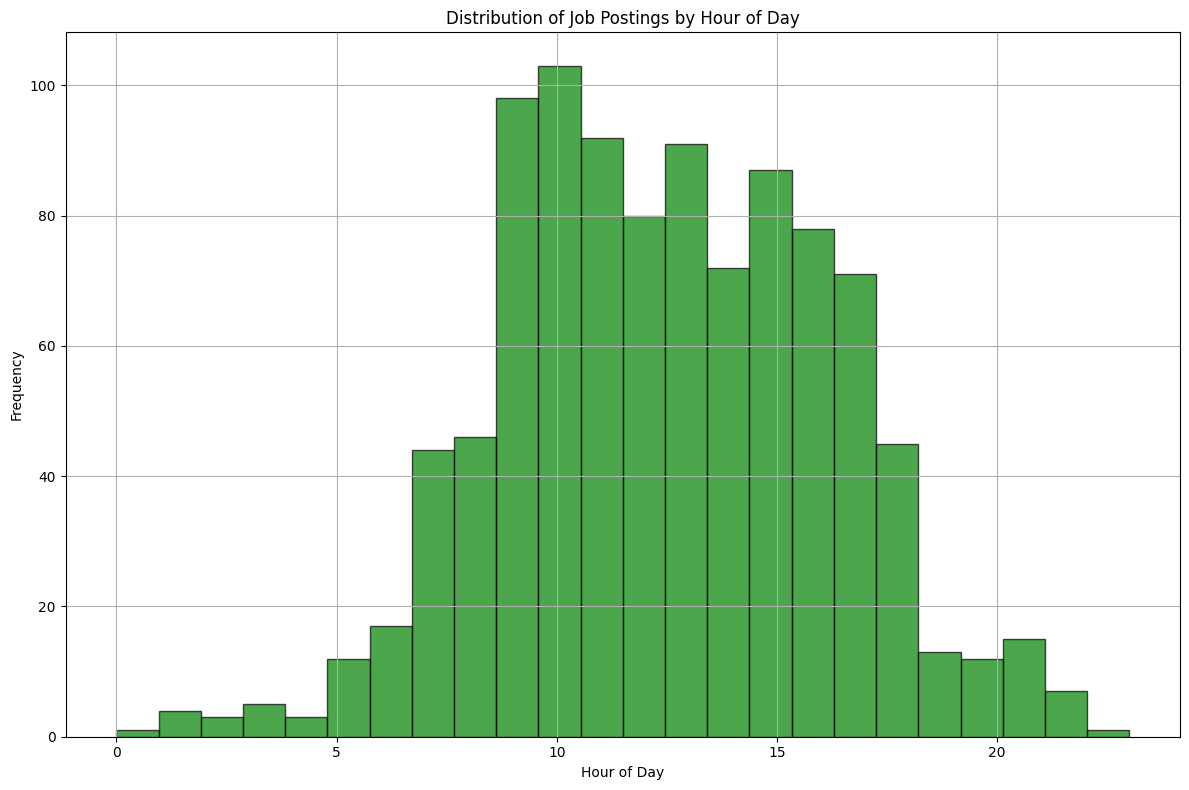

In [17]:
plt.figure(figsize=(12, 8))
plt.hist(pd.to_datetime(df['published_at']).dt.hour, bins=24, alpha=0.7, color='green', edgecolor='black')

plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Job Postings by Hour of Day')
plt.grid(True)
plt.tight_layout()
plt.show()

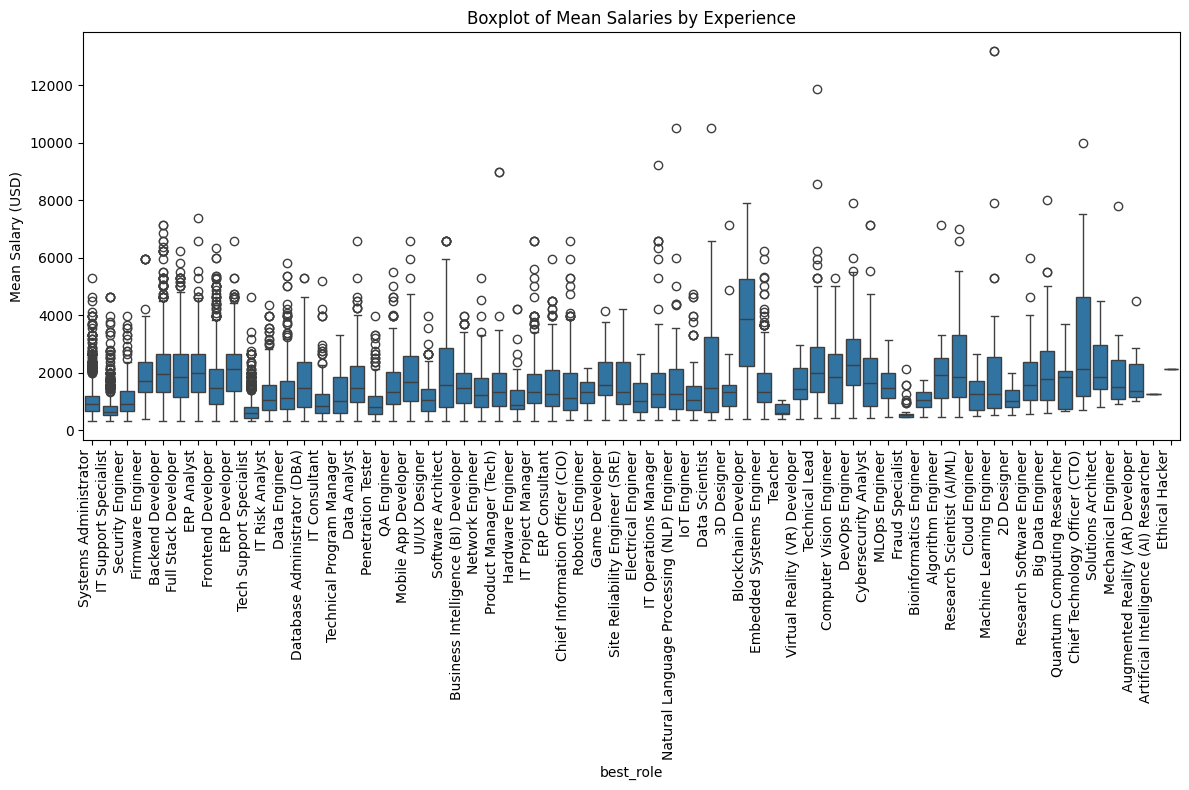

In [11]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='best_role', y='mean_salary_usd', data=df)


plt.ylabel('Mean Salary (USD)')
plt.title('Boxplot of Mean Salaries by Experience')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

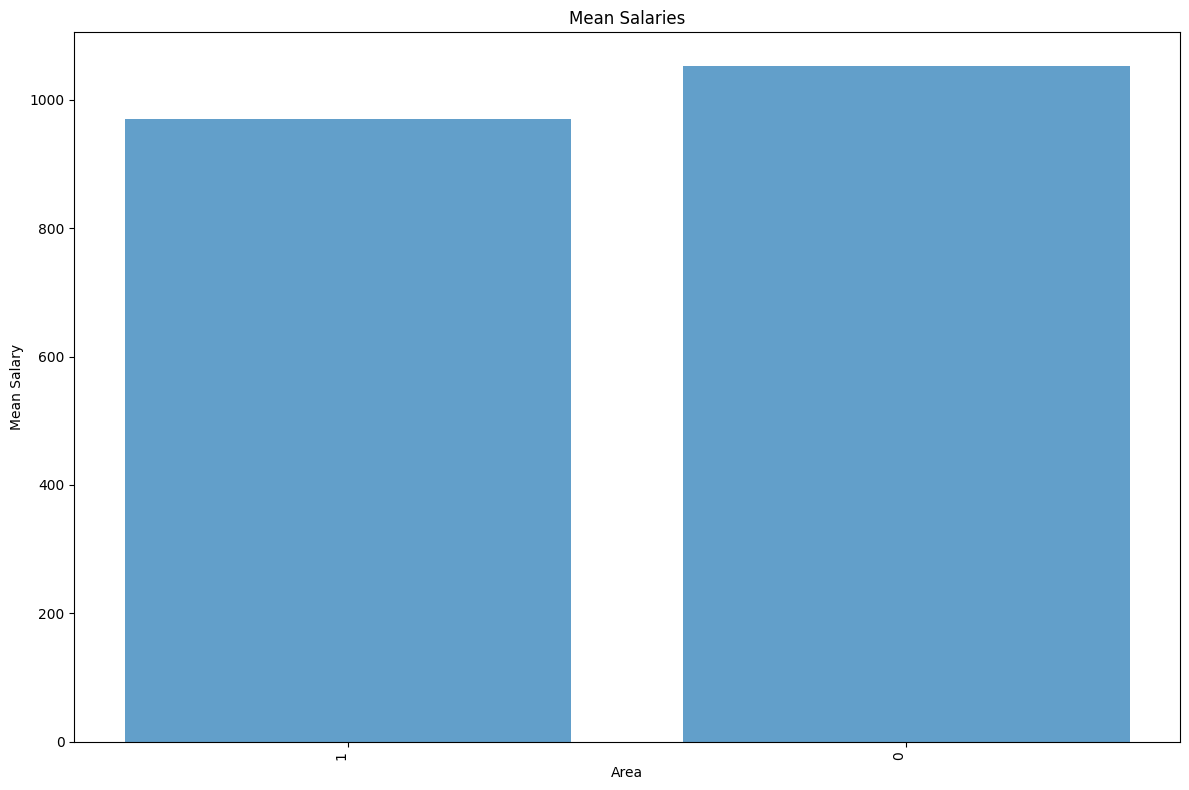

In [18]:
area_mean_salary = df.groupby('education')['mean_salary_usd'].median().sort_values(ascending=False)

# Plotting the mean salaries by area
plt.figure(figsize=(12, 8))
plt.bar(area_mean_salary.index, area_mean_salary.values, alpha=0.7)

plt.xlabel('Area')
plt.ylabel('Mean Salary')
plt.title('Mean Salaries')
plt.xticks(ticks=range(len(area_mean_salary.index)), labels=area_mean_salary.index, rotation=90, ha='right')
plt.tight_layout()
plt.show()


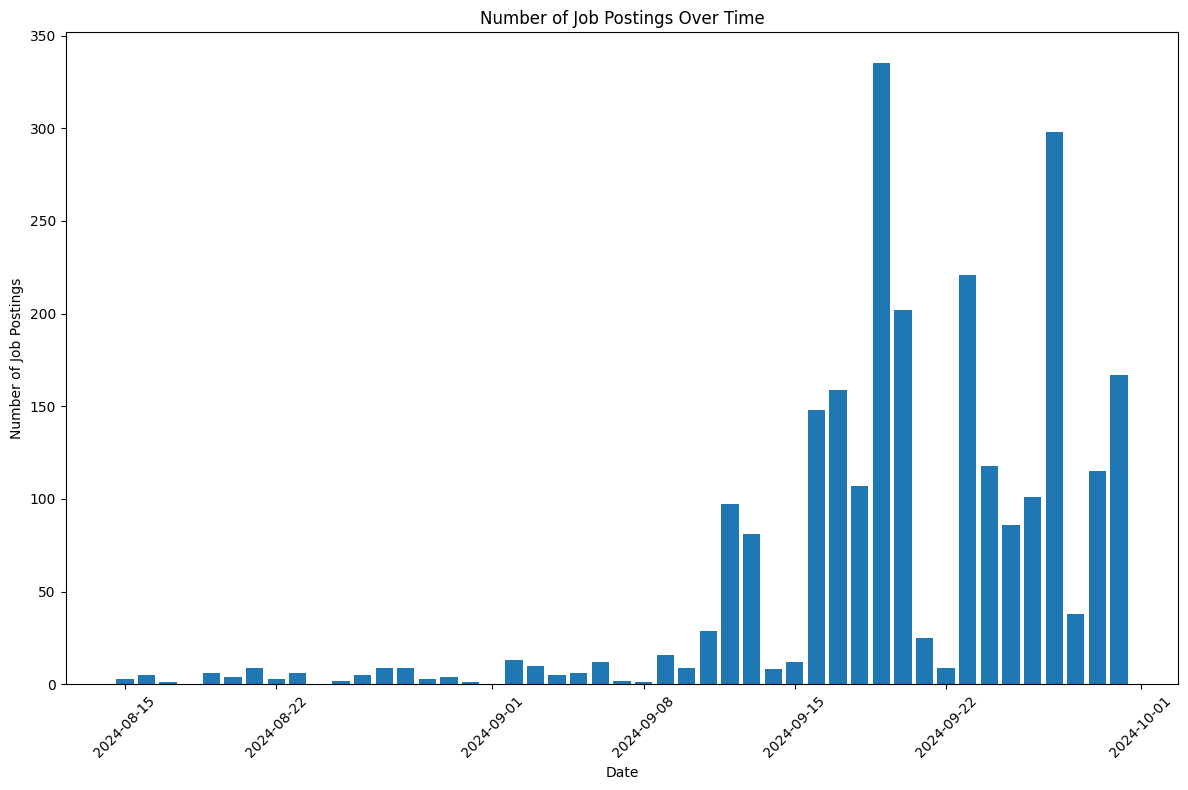

In [10]:
published_date_counts = df.groupby('published_date').size()

plt.figure(figsize=(12, 8))
plt.bar(published_date_counts.index, published_date_counts.values)

plt.xlabel('Date')
plt.ylabel('Number of Job Postings')
plt.title('Number of Job Postings Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
def prompt_template(template_params, model_name="gemma"):
    if "llama" in model_name.lower():
        return f"""
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert HR.
<|eot_id|><|start_header_id|>user<|end_header_id|>
{template_params}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
    elif "gemma" in model_name.lower():
        return f"""<start_of_turn>user
You are an expert HR.
{template_params}
<end_of_turn>
<start_of_turn>model
"""
    elif "mistral" in model_name.lower():
        return f"""<s>[INST] You are an expert HR. 
{template_params} [/INST]
"""
    elif "qwen" in model_name.lower():
        return f"""
<|im_start|>system
You are an expert HR.<|im_end|>
<|im_start|>user
{template_params}<|im_end|>
<|im_start|>assistant
"""

In [16]:
def build_translation_prompt(description):
    return prompt_template(f"""
Translate the following job description from Russian to English.
Maintain the original structure and formatting as much as possible.
Translate all technical terms accurately.
Return only the translated text, without any additional comments or explanations.

{description}
""", model_name="gemma")

print("Translating job descriptions from Russian to English")
result = llm.generate([build_translation_prompt(desc) for desc in df['description']], sampling_params)

df['description_en'] = [res.outputs[0].text.strip() for res in result]


Translating job descriptions from Russian to English


Processed prompts:   0%|          | 0/1000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 10-08 17:30:54 scheduler.py:1439] Sequence group 47 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts:  12%|█▏        | 124/1000 [00:49<08:00,  1.82it/s, est. speed input: 1234.67 toks/s, output: 814.50 toks/s]

WARNING 10-08 17:31:41 scheduler.py:1439] Sequence group 153 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51


Processed prompts:  27%|██▋       | 272/1000 [01:43<03:36,  3.36it/s, est. speed input: 1317.42 toks/s, output: 889.33 toks/s]

WARNING 10-08 17:32:35 scheduler.py:1439] Sequence group 302 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts:  40%|████      | 402/1000 [02:29<01:52,  5.32it/s, est. speed input: 1344.87 toks/s, output: 903.37 toks/s]

WARNING 10-08 17:33:21 scheduler.py:1439] Sequence group 439 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=151


Processed prompts:  55%|█████▍    | 547/1000 [03:23<02:13,  3.38it/s, est. speed input: 1347.05 toks/s, output: 909.82 toks/s]

WARNING 10-08 17:34:15 scheduler.py:1439] Sequence group 578 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=201


Processed prompts:  69%|██████▉   | 690/1000 [04:11<01:37,  3.19it/s, est. speed input: 1386.75 toks/s, output: 940.01 toks/s]

WARNING 10-08 17:35:03 scheduler.py:1439] Sequence group 726 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=251


Processed prompts:  83%|████████▎ | 831/1000 [04:55<00:56,  2.99it/s, est. speed input: 1433.42 toks/s, output: 971.51 toks/s]

WARNING 10-08 17:35:47 scheduler.py:1439] Sequence group 863 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=301


Processed prompts:  96%|█████████▋| 965/1000 [05:35<00:08,  3.97it/s, est. speed input: 1468.28 toks/s, output: 998.56 toks/s] 

WARNING 10-08 17:36:28 scheduler.py:1439] Sequence group 995 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=351


Processed prompts: 100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s, est. speed input: 1488.91 toks/s, output: 1011.96 toks/s]


In [ ]:
def build_summary_prompt(description):
    return prompt_template(f"""
Summarize following job description in English.
Infer all job requirements and add them to the summary
Add other key details like company info, seniority level and work type
Return only summary, do not add any additional info or headers. Do not add formatting
{description}
""", model_name="gemma")

print("Generating English summaries of job descriptions")
result = llm.generate([build_summary_prompt(desc) for desc in df['description']], sampling_params)

df['description_summary_en'] = [res.outputs[0].text.strip() for res in result]

In [ ]:
def build_data_role_prompt(name: str):
    return prompt_template(f"""
Here is a description of job vacancy. You need to determine if this vacancy is for an IT role.
Return only 1 or 0. DO NOT ADD ANY ADDITIONAL INFO
Description: {name}
""")

print("Generate data role feature")
result = llm.generate([build_data_role_prompt(name) for name in df['description_summary_en']], sampling_params)

df['is_it'] = [int(res.outputs[0].text.strip() == '1') for res in result]

In [ ]:
def build_customer_area_prompt(params):
    return prompt_template(f"""
You need to determine the customer location based on the job description.
If location is not specified assume that it is Russia.
Return only the country name. DO NOT ADD ANY ADDITIONAL INFO
Job Title: {params[0]}
Job Description: {params[1]}
""")

print("Generate customer area feature")
result = llm.generate(list(map(build_customer_area_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['customer_area'] = [res.outputs[0].text.strip().lower() for res in result]


def build_industry_prompt(params):
    return prompt_template(f"""
You are an expert HR. You need to determine company industry
Example of industries: technology, medicine, transportation, manufacturing, ecommerce, food etc
Name: {params[0]}
Description: {params[1]}
RETURN ONLY INDUSTRY. USE ONLY ENGLISH NAMES. DO NOT ADD ADDITIONAL INFO/FORMATTING
""")

print("Generate industry feature")
result = llm.generate(list(map(build_industry_prompt,  list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['industry'] = [res.outputs[0].text.strip().lower() for res in result]

def build_manager_prompt(name: str):
    return prompt_template(f"""
Here is a name of job vacancy. You need too determine if this is a manager role
Return only 1 or 0
Name: {name}
""")

print("Generate manager feature")
result = llm.generate(list(map(build_manager_prompt, list(df['name']))), sampling_params)

df['manager'] = [int(res.outputs[0].text.strip().lower() == '1') for res in result]

def build_work_type_prompt(params):
    return prompt_template(f"""
Here is a description of job vacancy. Return the work type that best describes this vacancy.
Name: {params[0]}
Description: {params[1]}
Return one work type from in office, remote, hybrid.
RETURN WORK TYPE ONLY FROM LIST ABOVE. DO NOT ADD ANY OTHER INFORMATION. USE ONLY ENGLISH
""")

print("Generate work type feature")
result = llm.generate(list(map(build_work_type_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['work_type'] = [res.outputs[0].text.strip().lower() for res in result]

def build_seniority_prompt(params):
    return prompt_template(f"""
Here is a description of job vacancy. Return the seniority level that best describes this vacancy.
Name: {params[0]}
Description: {params[1]}
Return one seniority level from intern, junior, middle, senior, lead, director.
RETURN LEVEL ONLY FROM LIST ABOVE. DO NOT ADD ANY OTHER INFORMATION. USE ONLY ENGLISH
""")

print("Generate seniority feature")
result = llm.generate(list(map(build_seniority_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['seniority'] = [res.outputs[0].text.strip().lower() for res in result]

In [7]:
df = df.sample(100, random_state=42)

In [50]:
import json

def fmt_result(obj):
    return str(obj)

def build_techstack_prompt(params):
    return prompt_template(f"""
Extract role and requorements from job description

#### 1. Example: Backend Developer
Job description: "We are looking for a backend developer to work with Python, Django, and Flask for building robust APIs. Experience with databases like PostgreSQL, MySQL, or SQLite is required. Familiarity with Docker for containerization and Git for version control is important. Knowledge of cloud platforms such as AWS, Azure, or GCP will be an advantage."

Result:
{
    fmt_result(
        {
            "role": "backend developer",
            "key_skills": ["python", "django", "flask", "postgresql", "docker", "git" "aws"],
        }
    )
}

#### 2. Example: Аналитик данных
Job description: "Ищем аналитика данных с хорошими знаниями Excel (включая сводные таблицы, макросы) для работы с большими объемами данных. Потребуются навыки работы с SQL (PostgreSQL, MySQL, SQLite). Опыт работы с инструментами визуализации данных, такими как Tableau или Power BI, приветствуется."

Result:
{
    fmt_result(
        {
            "role": "data analyst",
            "key_skills": ["excel", "sql", "tableau", "power bi"],
        }
    )
}

#### 3. Example: 1C Developer
Job description: "Требуется разработчик 1С с опытом работы в конфигурациях 1С: Управление торговлей и 1С: Бухгалтерия. Опыт работы с веб-сервисами и интеграция с CMS Bitrix (включая Bitrix24) будет преимуществом. Знание SQL (PostgreSQL, MySQL) также необходимо для работы с базами данных."

Result: 
{
    fmt_result(
        {
            "role": "erp developer",
            "key_skills": ["1c", "bitrix", "sql"],
        }
    )
}
                           
#### Format
Return data in json with next format
{
    fmt_result(
        {
            "role": "job role",
            "key_skills": ["skill_1", "skill_2", "skill_n"]
        }
    )
}
Do not add explanation and formatting.
Do not add comma to last element of an array.

#### Task
Use only english
Job description: {params[1]}
Result:
""", model_name='gemma')

print("Generate tech skills feature")
result = llm.generate(list(map(build_techstack_prompt, list(zip(df['name'], df['description'])))), sampling_params)

Generate tech skills feature


Processed prompts: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s, est. speed input: 4712.37 toks/s, output: 473.79 toks/s]


In [ ]:
def build_role_prompt(params):
    return prompt_template(f"""
You need to decide which role will candidate for this job perform
Select one from roles: Software Engineer, ML Engineer, ML OPS, Data Scientist, Data Analyst, Data Engineer, Dev OPS, Team Lead, Tech Support
Name: {params[0]}
Description: {params[1]}
DO NOT ADD LANGUAGE OR SOFTWARE TO ROLE NAME. DO NOT ADD ANY ADDITIONAL INFO
USE ONLY ENGLISH
Return only role
""", model_name='gemma')

print("Generate roles feature")
result = llm.generate(list(map(build_role_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['role'] = [res.outputs[0].text.strip().lower() for res in result]

In [3]:
from sklearn.cluster import DBSCAN

def find_clusters(embeddings, strings, eps=0.05):
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    clusters = dbscan.fit_predict(embeddings)

    # Create a dictionary to store clusters
    clustered_skills = {}
    for idx, label in enumerate(clusters):
        if label == -1:
            continue  # Skip noise
        if label not in clustered_skills:
            clustered_skills[label] = []
        clustered_skills[label].append(strings[idx])

    # Convert lists to sets for better handling of unique skills
    clustered_skills = {k: set(v) for k, v in clustered_skills.items()}

    return clustered_skills

In [ ]:
def build_cluster_map(clusters, item_embeddings_dict):
    cluster_map = {}
    for strings in clusters.values():
        # Get embeddings from precomputed dictionary
        embs = np.array([item_embeddings_dict[string] for string in strings])
        similarity_matrix = cosine_similarity(embs)
        mean_distances = np.mean(1 - similarity_matrix, axis=1)
        best_string = list(strings)[np.argmin(mean_distances)]
        for string in strings:
            cluster_map[string] = best_string
    return cluster_map

def count_unique_items(df, column_name, is_list_column=False):
    if is_list_column:
        return len(df[column_name].dropna().explode().str.strip().dropna().unique())
    else:
        return len(df[column_name].dropna().str.strip().dropna().unique())

def process_column(df, column_name, is_list_column=False, eps=0.05):
    # Get unique items
    if is_list_column:
        unique_items = df[column_name].dropna().explode().str.strip().dropna().unique()
    else:
        unique_items = df[column_name].dropna().str.strip().dropna().unique()
    
    unique_items_list = list(unique_items)
    
    # Get embeddings
    item_embeddings = embedding_model.encode(unique_items_list, show_progress_bar=True)
    
    # Build embeddings dictionary
    item_embeddings_dict = dict(zip(unique_items_list, item_embeddings))
    
    # Find clusters
    item_clusters = find_clusters(item_embeddings, unique_items_list, eps=eps)
    
    print(f'unique {column_name}: {len(unique_items)}')
    
    # Build cluster map
    item_map = build_cluster_map(item_clusters, item_embeddings_dict)
    
    # Mapping function
    def map_item(item):
        if pd.isnull(item):
            return item
        else:
            return item_map.get(item, item)
    
    # Print counts before and after collapsing
    before_count = count_unique_items(df, column_name, is_list_column)
    print(f"{column_name} before collapsing: {before_count}")
    
    # Apply mapping
    if is_list_column:
        df[column_name] = df[column_name].apply(lambda x: [map_item(it) for it in x])
    else:
        df[column_name] = df[column_name].apply(map_item)
    
    after_count = count_unique_items(df, column_name, is_list_column)
    print(f"{column_name} after collapsing: {after_count}")
    
    return df

# Apply the function to each column
df = process_column(df, 'tech_skills_v6', is_list_column=True, eps=0.07)
df = process_column(df, 'role', is_list_column=False)
df = process_column(df, 'industry', is_list_column=False)
df = process_column(df, 'seniority', is_list_column=False)
df = process_column(df, 'customer_area', is_list_column=False)

In [ ]:
df['work_type'].replace(
    {
        'in-office': 'in office',
        'office': 'in office',
        'remote/hybrid': 'hybrid,'
    },
    inplace=True,
)
work_type_counts = df['work_type'].value_counts()
selected_work_types = work_type_counts[work_type_counts > 100].index
df = df[df['work_type'].isin(selected_work_types)]
df.groupby('work_type')['id'].count()

In [ ]:
df['seniority'].replace(
    {
        'entry': 'intern',
        'entry-level': 'intern',
        'middle-senior': 'senior',
        'junior-middle': 'middle',
        'junior+': 'junior',
        'middle+': 'middle',
    },
    inplace=True,
)
df.groupby('seniority')['id'].count()

Encode categorial features

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

stop_words_ru = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords based on detected language
    tokens = [word for word in tokens if word not in stop_words_ru]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

df['preproc_summary_en'] = df['description_summary_en'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/netkit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/netkit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def tech_stack_to_string(tech_stack):
    return ' '.join(tech_stack)

# Convert tech_stack to string
df['tech_stack_str'] = df['tech_stack'].apply(tech_stack_to_string)

# Calculate embeddings
tech_stack_embeddings = embedding_model.encode(df['tech_stack_str'].tolist(), show_progress_bar=True, normalize_embeddings=True)

df['tech_stack_embedding'] = tech_stack_embeddings.tolist()

df.drop('tech_stack_str', axis=1, inplace=True)

print("Tech stack embeddings added to dataframe.")

Batches:   0%|          | 0/640 [00:00<?, ?it/s]

Tech stack embeddings added to dataframe.


In [42]:
df1 = df.copy()

In [43]:
target = 'mean_salary_usd'

# ['role', 'area', 'experience', 'schedule', 'employment', 'currency']

# One-hot encode 'experience', 'schedule', 'employment', and 'currency'
encoded_columns = ['experience', 'seniority', 'work_type']
df_encoded = pd.get_dummies(df1[encoded_columns], columns=encoded_columns, drop_first=True)

# Concatenate the encoded columns back to the original dataframe
df1 = pd.concat([df1, df_encoded], axis=1)

# Drop the original columns as they are now encoded
df1.drop(columns=encoded_columns, inplace=True)

# Calculate mean target encoding for 'area'
area_mean_target = df1.groupby('area')[target].mean()
df1['area_mean_target'] = df1['area'].map(area_mean_target)

# Calculate mean target encoding for 'area'
industry_mean_target = df1.groupby('industry')[target].mean()
df1['industry_mean_target'] = df1['industry'].map(industry_mean_target)

# Calculate mean target encoding for 'customer_area'
customer_area_mean_target = df1.groupby('customer_area')[target].mean()
df1['customer_area_mean_target'] = df1['customer_area'].map(customer_area_mean_target)

# Calculate mean target encoding for 'role'
role_mean_target = df1.groupby('role')[target].mean()
df1['role_mean_target'] = df1['role'].map(role_mean_target)

# Drop the original 'role' and 'area' columns as they are now encoded
df1.drop(columns=['area', 'industry', 'customer_area', 'role', 'best_role'], inplace=True)

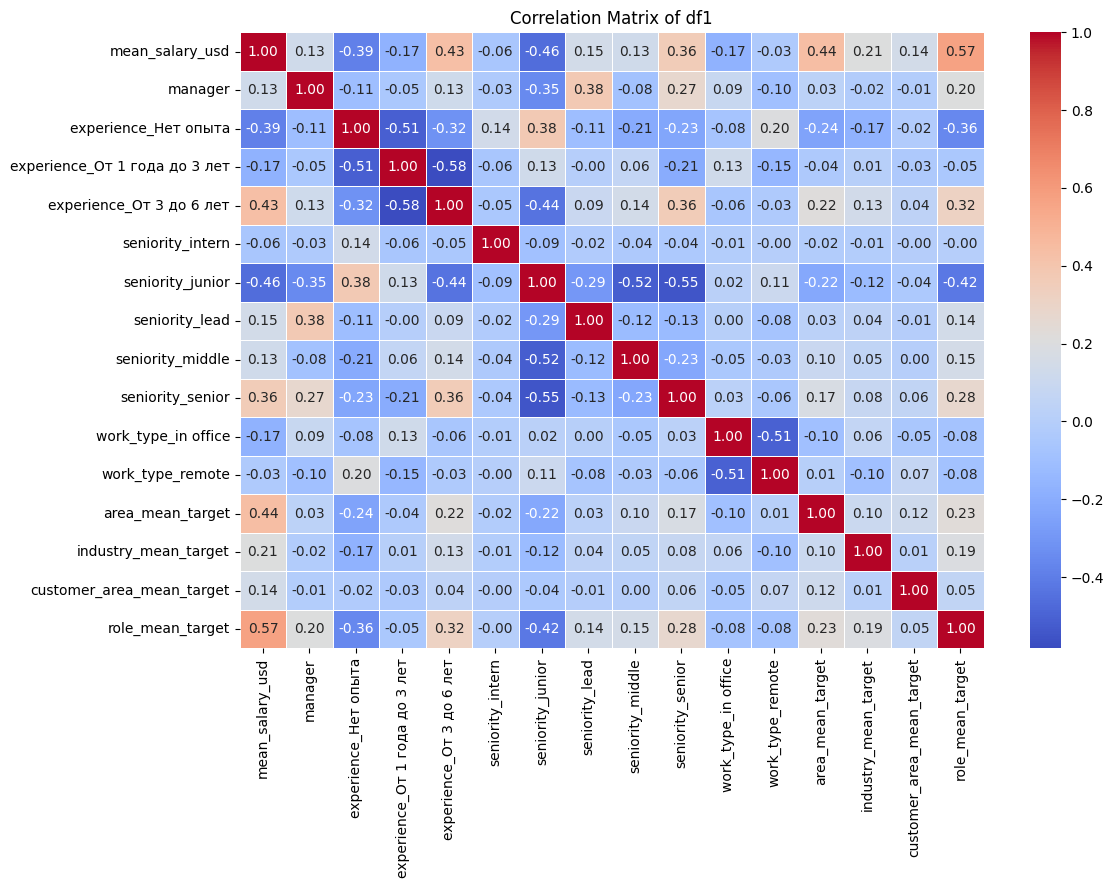

In [44]:
df1 = df1.drop(columns=['professional_roles', 'key_skills', 'mean_salary', 'salary_from', 'salary_to', 'id', 'published_at', 'published_date', 'languages', 'name', 'salary', 'employer', 'currency', 'education','employment', 'schedule', 'tech_stack', 'tech_skills_v2', 'tech_skills_v3', 'description_summary_en', 'preproc_summary_en', 'best_role_similarity'])

corr_matrix = df1.drop(columns=['tech_stack_embedding', 'description']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of df1')
plt.show()

In [16]:
def weighted_mape(y_true, y_pred, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (Weighted MAPE).
    
    Parameters:
    - y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) - Estimated target values.
    - weights: array-like of shape (n_samples,), optional - Weights for each sample. If None, use y_true as weights.
    
    Returns:
    - weighted_mape_value: float - The weighted MAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Default weights to y_true if not provided
    if weights is None:
        weights = np.abs(y_true)
    
    # Calculate the absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)
    
    # Weighted Mean Absolute Percentage Error
    weighted_mape_value = np.sum(weights * ape) / np.sum(weights) * 100
    
    return weighted_mape_value

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def evaluate(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    wmape = weighted_mape(y_test, y_pred)

    return {
        "r2": r2,
        "mae": mae,
        "mape": mape,
        "wmape": wmape,
    }

In [50]:
from sklearn.model_selection import train_test_split

X = df1.drop(columns=['mean_salary_usd'])
y = df1['mean_salary_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

y_train_tf = qt.fit_transform(y_train.values.reshape(-1, 1))
y_test_tf = qt.fit_transform(y_test.values.reshape(-1, 1))

y_train_lt = np.log1p(y_train)
y_test_lt= np.log1p(y_test)

train_pool = Pool(
    X_train, 
    y_train_lt, 
    embedding_features=['tech_stack_embedding'],
    text_features=['description'],
)
test_pool = Pool(
    X_test, 
    y_test_lt, 
    embedding_features=['tech_stack_embedding'],
    text_features=['description'],
)

pcts = [0.05, 0.5, 0.9]

optimal_params = {
    'iterations': 1000,
    'depth': 7,
    'learning_rate': 0.1,
}

cb_model_qt = CatBoostRegressor(
    **optimal_params,
    early_stopping_rounds=50,
    l2_leaf_reg=1,
    loss_function=f"MultiQuantile:alpha={','.join(map(str, pcts))}",
    # loss_function="MAE",
)
cb_model_qt.fit(train_pool, eval_set=test_pool)

# y_pred_cb = qt.inverse_transform(catboost_model.predict(X_test).reshape(-1, 1))
# y_pred_cb = catboost_model.predict(X_test)
y_pred_cb = np.expm1(cb_model_qt.predict(X_test))

feature_importances = cb_model_qt.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'][:50], feature_importance_df['importance'][:50], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()

In [52]:
sorted_indices = np.argsort(y_test)

sorted_y_test = y_test.iloc[sorted_indices][:-20]
sorted_y_pred_cb = y_pred_cb[sorted_indices][:-20]

Adjusted predictions:
{'r2': 0.7146633741068177, 'mae': 330.07093090843995, 'mape': 0.24708139601423987, 'wmape': 23.47287561974825}


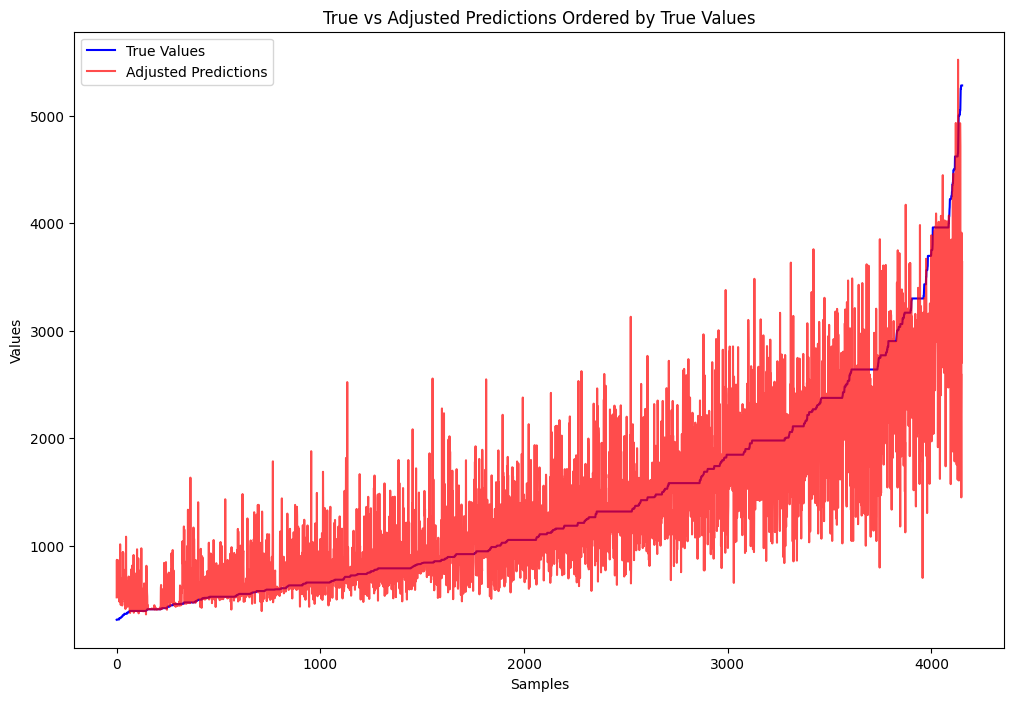

In [54]:
# Use 0 qt as reference, if estimation is less than 500 then use 0 qt, 
# if greater then use median between 1 and 2 qt
sorted_y_pred_cb_adjusted = np.where(
    np.median(sorted_y_pred_cb[:, 0:2], axis=1) < 350,
    sorted_y_pred_cb[:, 0],
    np.where(
        np.median(sorted_y_pred_cb[:, 1:3]) < 2500,
        sorted_y_pred_cb[:, 1],
        sorted_y_pred_cb[:, 2],
    )
)

print("Adjusted predictions:")
print(evaluate(sorted_y_test, sorted_y_pred_cb_adjusted))

plt.figure(figsize=(12, 8))
plt.plot(sorted_y_test.values, label='True Values', color='blue')
plt.plot(sorted_y_pred_cb_adjusted, label='Adjusted Predictions', color='red', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('True vs Adjusted Predictions Ordered by True Values')
plt.legend()
plt.show()

{'r2': 0.7146633741068177, 'mae': 330.07093090843995, 'mape': 0.24708139601423987, 'wmape': 23.47287561974825}


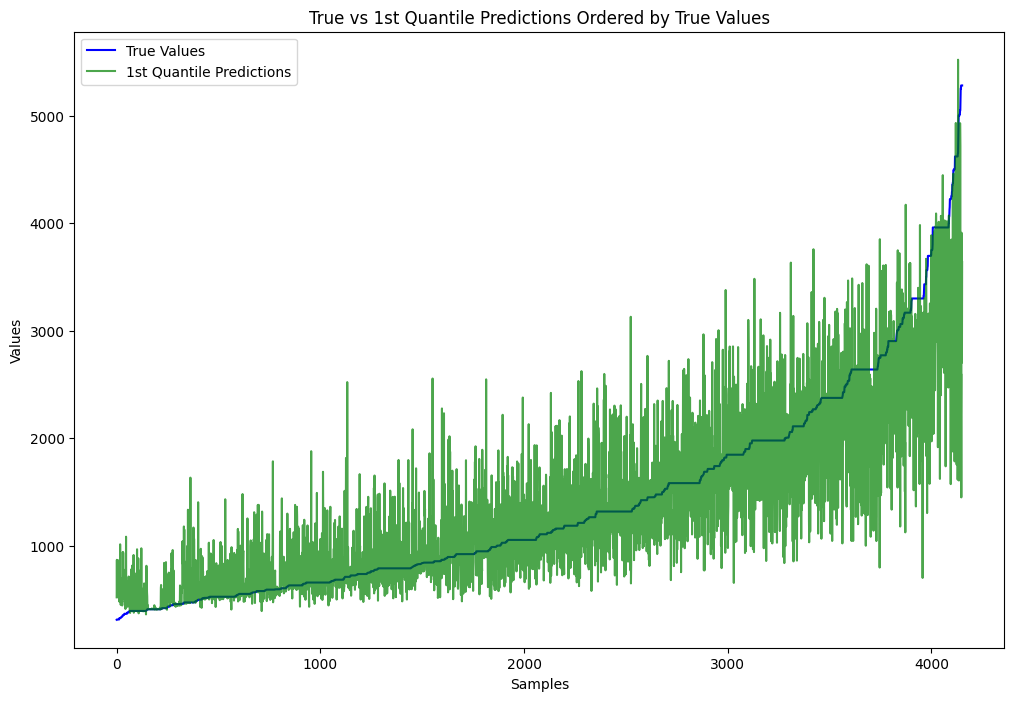

In [55]:
qt = 1

print(evaluate(sorted_y_test, sorted_y_pred_cb[:, qt]))

plt.figure(figsize=(12, 8))
plt.plot(sorted_y_test.values, label='True Values', color='blue')
plt.plot(sorted_y_pred_cb[:, qt], label='1st Quantile Predictions', color='green', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('True vs 1st Quantile Predictions Ordered by True Values')
plt.legend()
plt.show()


Adjusted predictions:
{'r2': 0.7704234570952274, 'mae': 267.4785590322693, 'mape': 0.19275013065583144, 'wmape': 19.0216415902907}


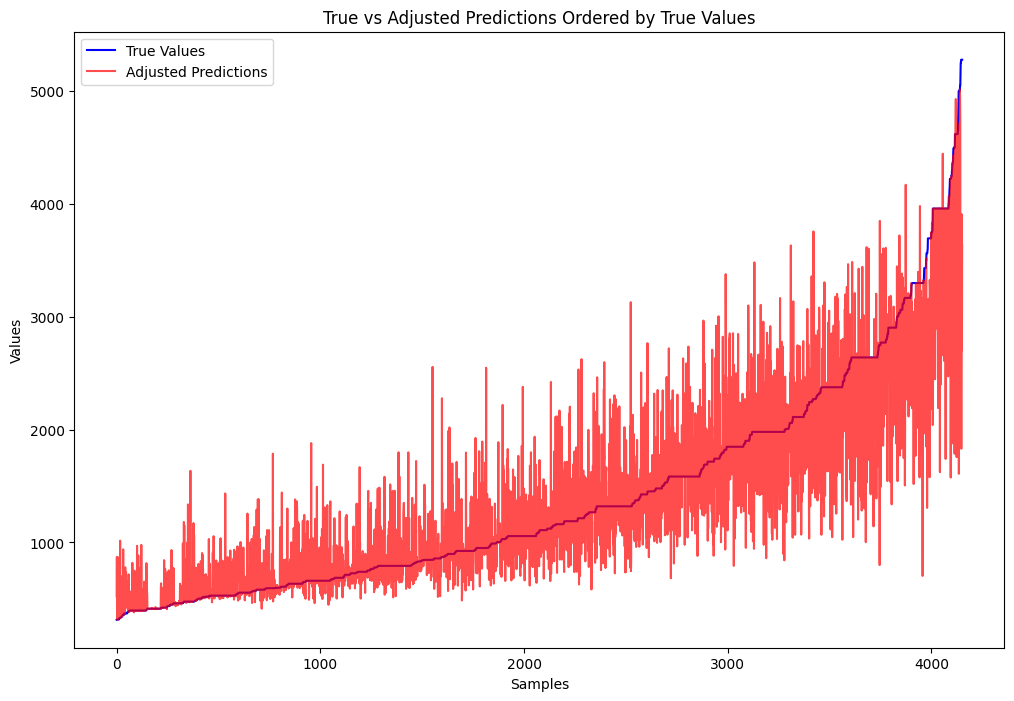

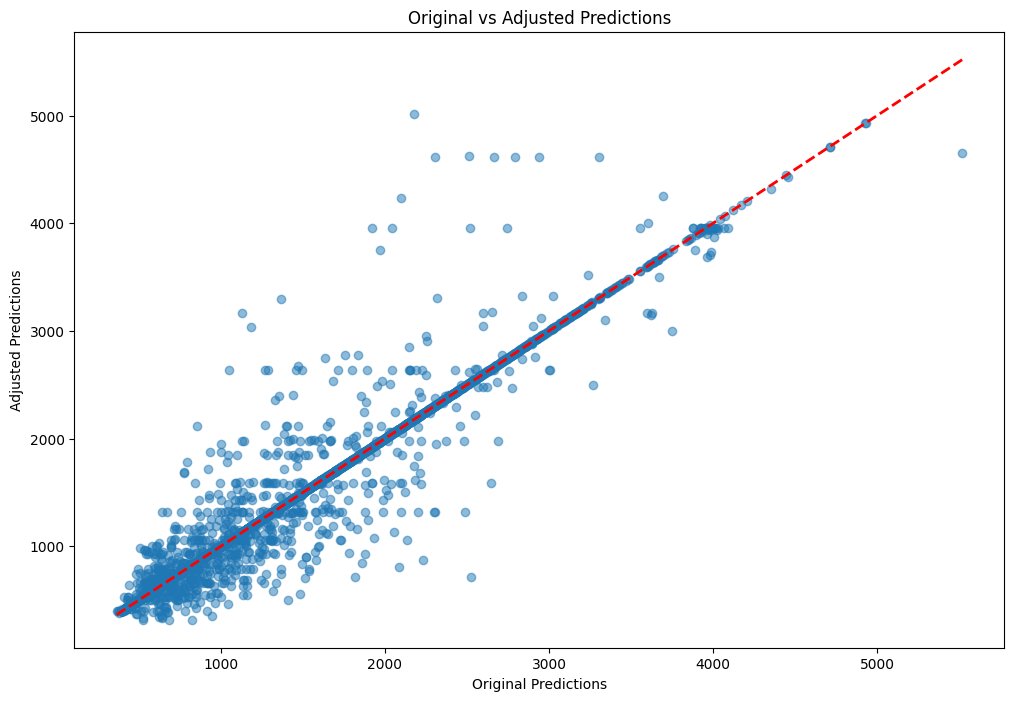


Summary Statistics:
       predicted_salary  adjusted_salary     25th_pct
count       4152.000000      4152.000000  4152.000000
mean        1361.619279      1367.304183   786.480887
std          798.890783       821.489550   558.452389
min          363.964869       316.789863   314.390766
25%          727.115038       722.547142   398.600845
50%         1131.491790      1122.259527   610.612460
75%         1828.369807      1847.940866   988.278775
max         5518.948375      5015.839493  5015.839493

Percentage of predictions adjusted: 24.16%


In [70]:
# Calculate 25th percentile (lower limit) and 99th percentile (upper limit) for each role and seniority
min_1th_percentile = df.groupby(['best_role', 'seniority', 'area'])['mean_salary_usd'].quantile(0.01).reset_index()
max_99th_percentile = df.groupby(['best_role', 'seniority', 'area'])['mean_salary_usd'].quantile(0.99).reset_index()

min_1th_percentile.rename({'mean_salary_usd': '25th_pct'}, inplace=True, axis=1)
max_99th_percentile.rename({'mean_salary_usd': '99th_pct'}, inplace=True, axis=1)

df_preds = df.iloc[X_test.index]
df_preds = df_preds.merge(min_1th_percentile, on=['best_role', 'seniority', 'area'], how='left')
df_preds = df_preds.merge(max_99th_percentile, on=['best_role', 'seniority', 'area'], how='left')

df_preds['predicted_salary'] = y_pred_cb[:, 1]
df_preds['adjusted_salary'] = np.clip(df_preds['predicted_salary'], 
                                      df_preds['25th_pct'], 
                                      df_preds['99th_pct'])

df_preds.sort_values(by='mean_salary_usd', inplace=True, ascending=True)
df_preds.reset_index(inplace=True)
df_preds = df_preds[:-20]

# Plot and evaluate adjusted salary
print("Adjusted predictions:")
print(evaluate(sorted_y_test, df_preds['adjusted_salary']))

plt.figure(figsize=(12, 8))
plt.plot(df_preds['mean_salary_usd'], label='True Values', color='blue')
plt.plot(df_preds['adjusted_salary'], label='Adjusted Predictions', color='red', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('True vs Adjusted Predictions Ordered by True Values')
plt.legend()
plt.show()

# Compare original predictions vs adjusted predictions
plt.figure(figsize=(12, 8))
plt.scatter(df_preds['predicted_salary'], df_preds['adjusted_salary'], alpha=0.5)
plt.plot([df_preds['predicted_salary'].min(), df_preds['predicted_salary'].max()], 
         [df_preds['predicted_salary'].min(), df_preds['predicted_salary'].max()], 
         'r--', lw=2)
plt.xlabel('Original Predictions')
plt.ylabel('Adjusted Predictions')
plt.title('Original vs Adjusted Predictions')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(df_preds[['predicted_salary', 'adjusted_salary', '25th_pct']].describe())

# Calculate and print the percentage of predictions that were adjusted
percent_adjusted = (df_preds['adjusted_salary'] != df_preds['predicted_salary']).mean() * 100
print(f"\nPercentage of predictions adjusted: {percent_adjusted:.2f}%")

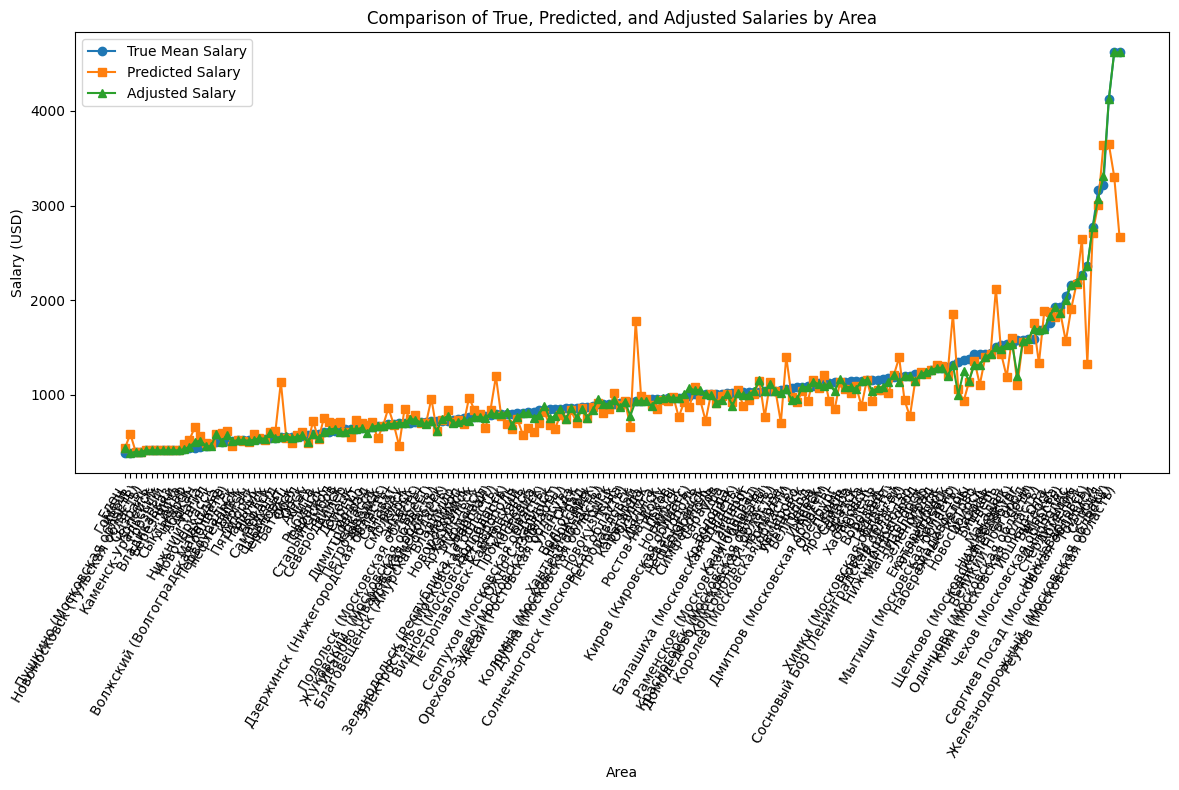


Summary Statistics by Area:
                                 area   true_mean    true_std   pred_mean    pred_std    adj_mean     adj_std
                               Абакан  448.785639   36.958817  559.273988  199.046845  514.467112  123.320436
                                Адлер  633.579725         NaN  553.387091         NaN  633.579725         NaN
           Аксай (Ростовская область)  857.972545  280.005325  835.502775    1.408537  857.972545  280.005325
                                Актау  584.245622   91.805342  719.014684   66.699296  584.245622   91.805342
                               Алматы 1037.517114  529.377073 1132.720743  446.578732 1114.113726  466.791181
                          Альметьевск 1314.413939 1503.886795 1857.338531 1505.114983 1314.413939 1503.886795
                                Анапа  457.585357   80.650751  492.395700   38.382748  460.309746   84.084897
                              Ангарск  440.865892   85.868300  654.041078  115.346607  500.

In [72]:
# Plot comparisons between predictions by area
plt.figure(figsize=(12, 8))

# Group by area and calculate mean salaries
area_comparison = df_preds.groupby('area').agg({
    'mean_salary_usd': 'mean',
    'predicted_salary': 'mean',
    'adjusted_salary': 'mean'
}).reset_index()

# Sort by true mean salary for better visualization
area_comparison = area_comparison.sort_values('mean_salary_usd')

# Plot
x = range(len(area_comparison))
plt.plot(x, area_comparison['mean_salary_usd'], 'o-', label='True Mean Salary')
plt.plot(x, area_comparison['predicted_salary'], 's-', label='Predicted Salary')
plt.plot(x, area_comparison['adjusted_salary'], '^-', label='Adjusted Salary')

plt.xlabel('Area')
plt.ylabel('Salary (USD)')
plt.title('Comparison of True, Predicted, and Adjusted Salaries by Area')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(x, area_comparison['area'], rotation=60, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics by area
print("\nSummary Statistics by Area:")
summary_by_area = df_preds.groupby('area').agg({
    'mean_salary_usd': ['mean', 'std'],
    'predicted_salary': ['mean', 'std'],
    'adjusted_salary': ['mean', 'std']
}).reset_index()
summary_by_area.columns = ['area', 'true_mean', 'true_std', 'pred_mean', 'pred_std', 'adj_mean', 'adj_std']
print(summary_by_area.to_string(index=False))


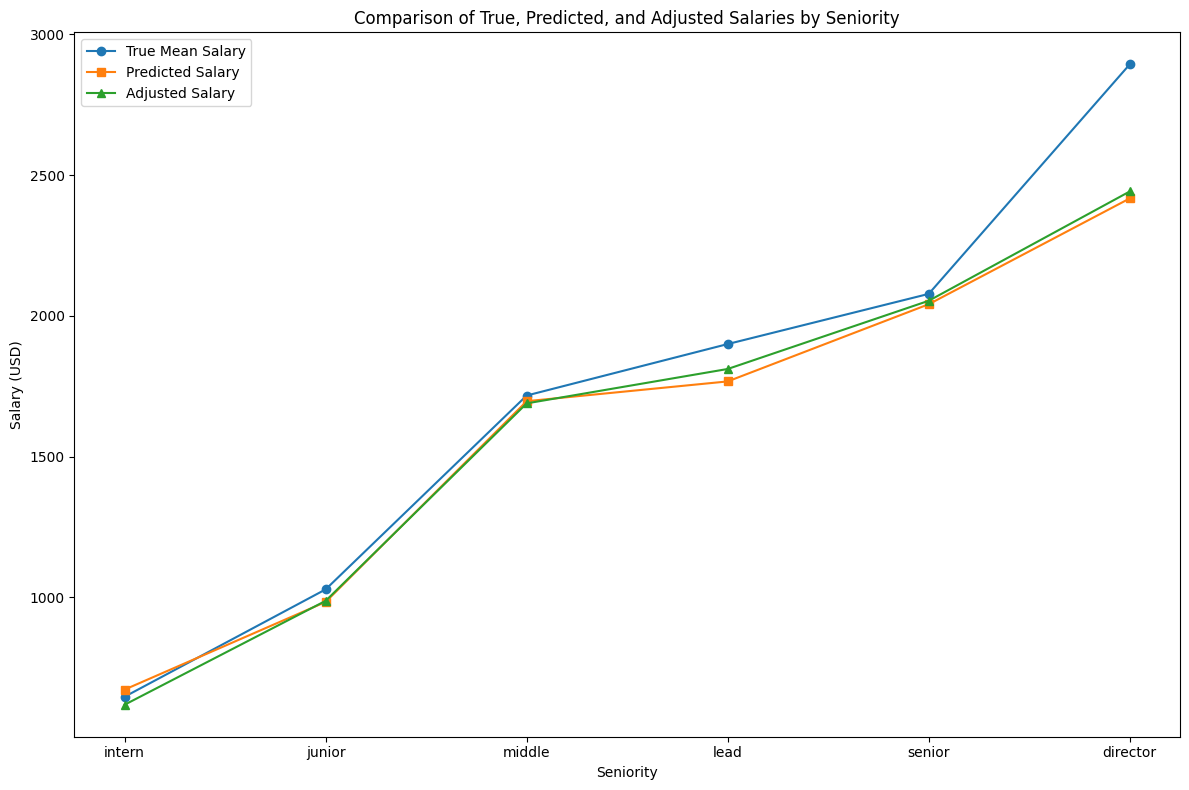


Summary Statistics by Seniority:
seniority   true_mean    true_std   pred_mean   pred_std    adj_mean    adj_std
 director 2893.347413 1599.448980 2417.229365 888.194664 2441.925527 994.246034
   intern  647.696988  341.798740  673.041908 107.929445  619.278920 198.869315
   junior 1028.859045  691.826169  984.325949 558.999964  988.175587 564.992320
     lead 1900.055989 1102.435286 1767.362008 817.826294 1811.537733 912.734550
   middle 1717.283375  857.276458 1697.108150 691.024921 1689.391834 699.398198
   senior 2078.242724 1074.700060 2041.416838 839.883276 2053.751036 890.473096


In [73]:
# Plot comparisons between predictions by seniority
plt.figure(figsize=(12, 8))

# Group by seniority and calculate mean salaries
seniority_comparison = df_preds.groupby('seniority').agg({
    'mean_salary_usd': 'mean',
    'predicted_salary': 'mean',
    'adjusted_salary': 'mean'
}).reset_index()

# Sort by true mean salary for better visualization
seniority_comparison = seniority_comparison.sort_values('mean_salary_usd')

# Plot
x = range(len(seniority_comparison))
plt.plot(x, seniority_comparison['mean_salary_usd'], 'o-', label='True Mean Salary')
plt.plot(x, seniority_comparison['predicted_salary'], 's-', label='Predicted Salary')
plt.plot(x, seniority_comparison['adjusted_salary'], '^-', label='Adjusted Salary')

plt.xlabel('Seniority')
plt.ylabel('Salary (USD)')
plt.title('Comparison of True, Predicted, and Adjusted Salaries by Seniority')
plt.legend()

# Set x-axis labels
plt.xticks(x, seniority_comparison['seniority'])

plt.tight_layout()
plt.show()

# Print summary statistics by seniority
print("\nSummary Statistics by Seniority:")
summary_by_seniority = df_preds.groupby('seniority').agg({
    'mean_salary_usd': ['mean', 'std'],
    'predicted_salary': ['mean', 'std'],
    'adjusted_salary': ['mean', 'std']
}).reset_index()
summary_by_seniority.columns = ['seniority', 'true_mean', 'true_std', 'pred_mean', 'pred_std', 'adj_mean', 'adj_std']
print(summary_by_seniority.to_string(index=False))


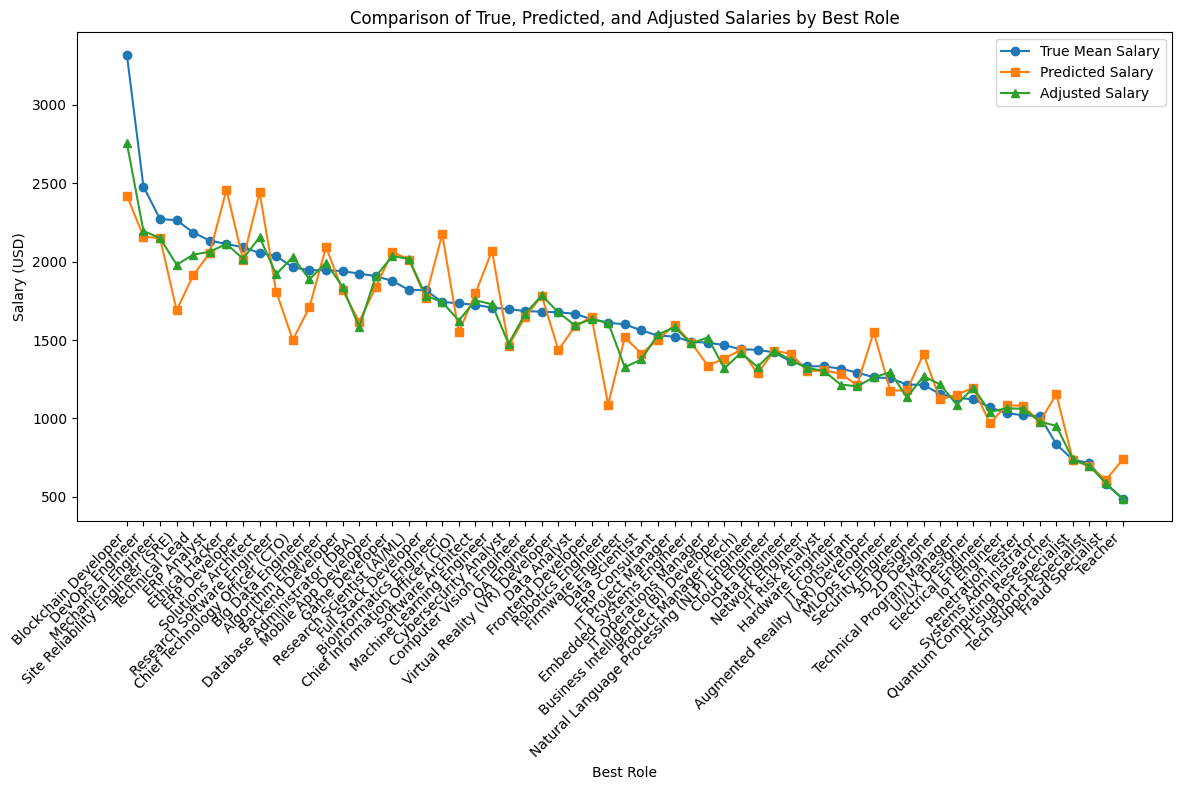


Summary Statistics by Best Role:
                                 best_role   true_mean    true_std   pred_mean    pred_std    adj_mean     adj_std
                               2D Designer 1155.332629  414.070123 1121.267688  348.160719 1217.528596  314.046086
                               3D Designer 1214.549996  723.668241 1410.766993  775.317588 1269.383691  795.570702
                        Algorithm Engineer 1944.737768  857.363117 2091.630611  665.339495 1992.692652  784.559023
          Augmented Reality (AR) Developer 1262.759592  148.360747 1549.569880  468.007251 1261.879620  148.681392
                         Backend Developer 1938.821650  950.057398 1816.420621  714.664985 1838.862990  736.484384
                         Big Data Engineer 1944.875264 1183.403587 1709.295802  691.631252 1886.911333  965.597259
                   Bioinformatics Engineer 1742.344245         NaN 2174.889473         NaN 1742.344245         NaN
                      Blockchain Developer 331

In [75]:
# Plot comparisons between predictions by best role
plt.figure(figsize=(12, 8))

# Group by best_role and calculate mean salaries
role_comparison = df_preds.groupby('best_role').agg({
    'mean_salary_usd': 'mean',
    'predicted_salary': 'mean',
    'adjusted_salary': 'mean'
}).reset_index()

# Sort by true mean salary for better visualization
role_comparison = role_comparison.sort_values('mean_salary_usd', ascending=False)

# Plot
x = range(len(role_comparison))
plt.plot(x, role_comparison['mean_salary_usd'], 'o-', label='True Mean Salary')
plt.plot(x, role_comparison['predicted_salary'], 's-', label='Predicted Salary')
plt.plot(x, role_comparison['adjusted_salary'], '^-', label='Adjusted Salary')

plt.xlabel('Best Role')
plt.ylabel('Salary (USD)')
plt.title('Comparison of True, Predicted, and Adjusted Salaries by Best Role')
plt.legend()

# Set x-axis labels
plt.xticks(x, role_comparison['best_role'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics by best role
print("\nSummary Statistics by Best Role:")
summary_by_role = df_preds.groupby('best_role').agg({
    'mean_salary_usd': ['mean', 'std'],
    'predicted_salary': ['mean', 'std'],
    'adjusted_salary': ['mean', 'std']
}).reset_index()
summary_by_role.columns = ['best_role', 'true_mean', 'true_std', 'pred_mean', 'pred_std', 'adj_mean', 'adj_std']
print(summary_by_role.to_string(index=False))